In [2]:
import pandas as pd
import bioframe as bf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import bbi
from gtfparse import read_gtf

# Looking into relationship with distal enhancers

### Gathering references

In [3]:
# TSS annotations
# deseq2 results

In [4]:
# importing reference tables and data outputs for the RNA-seq analysis

# outputs from basic-sleuth-mm9 mapping
deseq_results_folder = "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/deseq-mm9-results/"

# sample 2 conditions extracted from this project metadata
s2c = pd.read_csv("/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/supplementary/s2c.csv", index_col = 0)

# t2g to compare gene-level analysis
t2g = pd.read_csv("/project/fudenber_735/genomes/mm9/ensembl/ensembl_relational_downloads/biomaRt_mm9_t2g.csv", index_col = 0)

# DE results reported by paper (FPKM)
fpkm = pd.read_csv("/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/supplementary/supplement-10_RNA_seq_FPKM.csv", index_col=0)

In [5]:
# Gene annotations, references

# Reading gtf file that contains only the parsed TSSes
tss_df = read_gtf('/project/fudenber_735/genomes/mm9/ensembl/tsses.gtf')
# enhancer coordinates from elphege
enhancer_coords = bf.read_table('/project/fudenber_735/collaborations/karissa_2022/features/mm9/mESC_Enhancer_prediction_Chen12_BMCgenomics_mm9.bed',
                               schema='bedGraph',
                               skiprows=1)

# cleaning out less-well defined chromosome numbers
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('NT_'))]
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('MT'))]

# paste 'chr' to all chromosome names
tss_df["seqname"] = 'chr' + tss_df["seqname"]

# rename column to chrom to match bedframe/bioframe format
tss_df = tss_df.rename(columns= {"seqname" : "chrom"})

/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['transcript_id', 'gene_id']


### Taking a look at feature data

* tss_df was generated for mm9 using gtfutils (can see source in TSS_heatmaps_deseq)
* enhancer_coords from chen 2012 --> to follow the paper we'll filter based on a probability threshold of 0.8

In [6]:
tss_df

,chrom,source,feature,start,end,score,strand,frame,transcript_id,gene_id
0,chr3,gffutils_derived,transcript,107949065,107949065,NaN,-,0,ENSMUST00000000001,ENSMUSG00000000001
1,chrX,gffutils_derived,transcript,75098963,75098963,NaN,-,0,ENSMUST00000000003,ENSMUSG00000000003
2,chrX,gffutils_derived,transcript,75098870,75098870,NaN,-,0,ENSMUST00000114041,ENSMUSG00000000003
3,chr16,gffutils_derived,transcript,18812066,18812066,NaN,-,0,ENSMUST00000000028,ENSMUSG00000000028
4,chr16,gffutils_derived,transcript,18811720,18811720,NaN,-,0,ENSMUST00000096990,ENSMUSG00000000028
...,...,...,...,...,...,...,...,...,...,...
95878,chr10,gffutils_derived,transcript,62020939,62020939,NaN,+,0,ENSMUST00000175629,ENSMUSG00000093370
95879,chr10,gffutils_derived,transcript,79964657,79964657,NaN,-,0,ENSMUST00000175630,ENSMUSG00000093371
95880,chr8,gffutils_derived,transcript,126139118,126139118,NaN,-,0,ENSMUST00000175631,ENSMUSG00000093372
95881,chr19,gffutils_derived,transcript,35351013,35351013,NaN,-,0,ENSMUST00000175632,ENSMUSG00000093373


In [7]:
# replacing value string with a decimal
enhancer_coords['value'] = enhancer_coords['value'].apply(lambda x: x.replace(',', '.')).astype(float)

enhancer_coords.dtypes

chrom     object
start      int64
end        int64
value    float64
dtype: object

In [8]:
# Taking cutoff
enhancer_coords = enhancer_coords.loc[np.where(enhancer_coords['value'] >= 0.8)]

# Displaying last 5 --> the original data was ordered descending by 'value'
enhancer_coords.tail(5)

,chrom,start,end,value
1272,chr18,77381001,77382000,0.8005
1273,chr9,78222001,78223000,0.8004
1274,chr1,138467001,138468000,0.8003
1275,chr14,12940001,12941000,0.8000
1276,chr2,135388001,135389000,0.8000


## Variation 1: dCTCF DEGs mapped to mm9 (kallisto, DESeq)

- [x] download enhancer coords
- [x] apply TSS annotation to everything
- [x] separate DEGs by up, down, or unchanged
- [x] get all distances from tss to enhancers (bioframe func -- should be baby)
- [x] sort by distances
- [x] plottttyyyyy

In [9]:
# looks to be the right format
bf.SCHEMAS['bedGraph']

['chrom', 'start', 'end', 'value']

In [10]:
enhancer_coords

,chrom,start,end,value
0,chr3,34660001,34661000,1.0000
1,chr7,3206001,3207000,1.0000
2,chr8,91527001,91528000,1.0000
3,chr9,110850001,110851000,1.0000
4,chr12,87842001,87843000,0.9999
...,...,...,...,...
1272,chr18,77381001,77382000,0.8005
1273,chr9,78222001,78223000,0.8004
1274,chr1,138467001,138468000,0.8003
1275,chr14,12940001,12941000,0.8000


In [11]:
# import DEseq results

# Importing the .csv outputs from sleuth WT for each of the conditions into pandas dataframes:
basic_deseq_results = {}

# list of all the conditions for which we generated results
conditions = s2c['condition'].unique()
conditions = [x.strip().replace("-","_").split("RNA_seq_")[1] for x in conditions]

# put em in dictionary so we can get results by name (I think there might be built-in objects that do that in daler's meta-seq package --> look into some day
for c in conditions[1:]:
    
    df = pd.read_csv(deseq_results_folder+"pairwise_deseq_wt_"+c+".csv")
    basic_deseq_results[c] = df.rename(columns={"Unnamed: 0" : 'gene_id'})


In [12]:
# when we merge the TSS into the result df --> how many do not have a TSS to map? how many entries are lost?
print(len(basic_deseq_results['CTCF_AID_auxin1day']))
tss_deseq_res = basic_deseq_results['CTCF_AID_auxin1day'].merge(tss_df.drop_duplicates(['gene_id']), how='inner', on='gene_id')
print(len(tss_deseq_res))


26520
25785


In [13]:
# Filtering by significant (padj<0.5) --> separate by up-regulated and down-regulated
up_ix = np.where((tss_deseq_res['padj'] < 0.05) & (tss_deseq_res['log2FoldChange'] > 0))
down_ix = np.where((tss_deseq_res['padj'] < 0.05) & (tss_deseq_res['log2FoldChange'] < 0))
nonsig_ix = np.where(tss_deseq_res['padj'] >= 0.05)

# Quick count to confirm this is filtering the same as earlier
print("number up up-regulated genes: " + str(len(tss_deseq_res.iloc[up_ix])))
print("number up down-regulated genes: " + str(len(tss_deseq_res.iloc[down_ix])))

number up up-regulated genes: 129
number up down-regulated genes: 158


summary from DESEq2:

```
out of 22072 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 130, 0.59%
LFC < 0 (down)     : 159, 0.72%
outliers [1]       : 86, 0.39%
low counts [2]     : 5504, 25%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results
```

In [14]:
# Since we were getting a log-error, see if there are any distances that = 0
closest_intervals = bf.closest(tss_deseq_res, enhancer_coords, suffixes=('_de_tss','_enhancer'))
tss_deseq_res['distance_to_enhancer'] = closest_intervals['distance']

print(len(tss_deseq_res[tss_deseq_res['distance_to_enhancer'] == 0]))
np.log10(tss_deseq_res[tss_deseq_res['distance_to_enhancer'] == 0]['distance_to_enhancer'])

5


/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/pandas/core/arrays/masked.py:484: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)


5811    -inf
9752    -inf
10452   -inf
16701   -inf
23041   -inf
Name: distance_to_enhancer, dtype: Float64

In [15]:
print(len(tss_deseq_res[pd.isna(tss_deseq_res['distance_to_enhancer'])]))
tss_deseq_res.tail(13)

12


,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chrom,source,feature,start,end,score,strand,frame,transcript_id,distance_to_enhancer
25772,ENSMUSG00000084404,1.865468,1.088138,1.840053,0.591362,0.554278,NaN,chr4,gffutils_derived,transcript,55422180,55422180,NaN,-,0,ENSMUST00000118617,923437
25773,ENSMUSG00000084405,0.000000,NaN,NaN,NaN,NaN,NaN,chr2,gffutils_derived,transcript,88037620,88037620,NaN,+,0,ENSMUST00000121437,<NA>
25774,ENSMUSG00000084406,0.000000,NaN,NaN,NaN,NaN,NaN,chr4,gffutils_derived,transcript,121982890,121982890,NaN,+,0,ENSMUST00000118468,<NA>
25775,ENSMUSG00000084407,0.266680,1.835794,4.037416,0.454695,0.649329,NaN,chr2,gffutils_derived,transcript,121311167,121311167,NaN,+,0,ENSMUST00000119042,<NA>
25776,ENSMUSG00000084408,10.566498,-0.071127,0.791961,-0.089811,0.928437,0.999805,chr4,gffutils_derived,transcript,15939474,15939474,NaN,-,0,ENSMUST00000119255,<NA>
25777,ENSMUSG00000084409,1.111532,-0.575257,2.867222,-0.200632,0.840986,NaN,chrX,gffutils_derived,transcript,66246106,66246106,NaN,+,0,ENSMUST00000118512,<NA>
25778,ENSMUSG00000084410,5.151212,1.207003,1.291019,0.934923,0.349828,0.999805,chrX,gffutils_derived,transcript,21376437,21376437,NaN,+,0,ENSMUST00000118331,<NA>
25779,ENSMUSG00000084411,7.408594,-0.560611,1.171068,-0.478718,0.632139,0.999805,chr11,gffutils_derived,transcript,88247017,88247017,NaN,-,0,ENSMUST00000120278,<NA>
25780,ENSMUSG00000084412,0.000000,NaN,NaN,NaN,NaN,NaN,chr11,gffutils_derived,transcript,21351358,21351358,NaN,-,0,ENSMUST00000120335,<NA>
25781,ENSMUSG00000084413,9.829391,1.454489,1.157044,1.257073,0.208727,0.999805,chr11,gffutils_derived,transcript,17874794,17874794,NaN,-,0,ENSMUST00000122453,<NA>


### A little more clean-up following finding enhancer-distance 

Taking a look --> none of the genes which could not find an enhancer seem to be DE genes (all have high / non-sign. p_adj). 

* Removed genes that did not find an enhancer
* Setting genes where distance from TSS to enhancer == 0 --> = 1 instead 

In [16]:
# Replace distance_to_enhancer == 0
tss_deseq_res['distance_to_enhancer'] = tss_deseq_res['distance_to_enhancer'].replace(0, 1)

# Remove distance_to_enhancer = NA
tss_deseq_res.dropna(subset='distance_to_enhancer', inplace=True)

In [17]:
bf.is_bedframe(tss_deseq_res)

True

In [18]:
bf.is_bedframe(enhancer_coords)

True

# Replicating Figure 6(d) from Nora 2017

1. Using deseq2 results for 1 day, 2 days, or 4 days of auxin degradation treatment + mm9 enhancer coordinate predictions from Chen12_BMCgenomics (provided by Elphege)
2. Using excel file of DE results reported by the paper

For condition CTCF_AID_auxin1day, there are 287 DE genes out of 25773 total (that have a mappable TSS)
Number of up-regulated genes: 129
Number of down-regulated genes: 158

For condition CTCF_AID_auxin2days, there are 885 DE genes out of 25773 total (that have a mappable TSS)
Number of up-regulated genes: 568
Number of down-regulated genes: 317

For condition CTCF_AID_auxin4days, there are 3900 DE genes out of 25773 total (that have a mappable TSS)
Number of up-regulated genes: 2184
Number of down-regulated genes: 1716



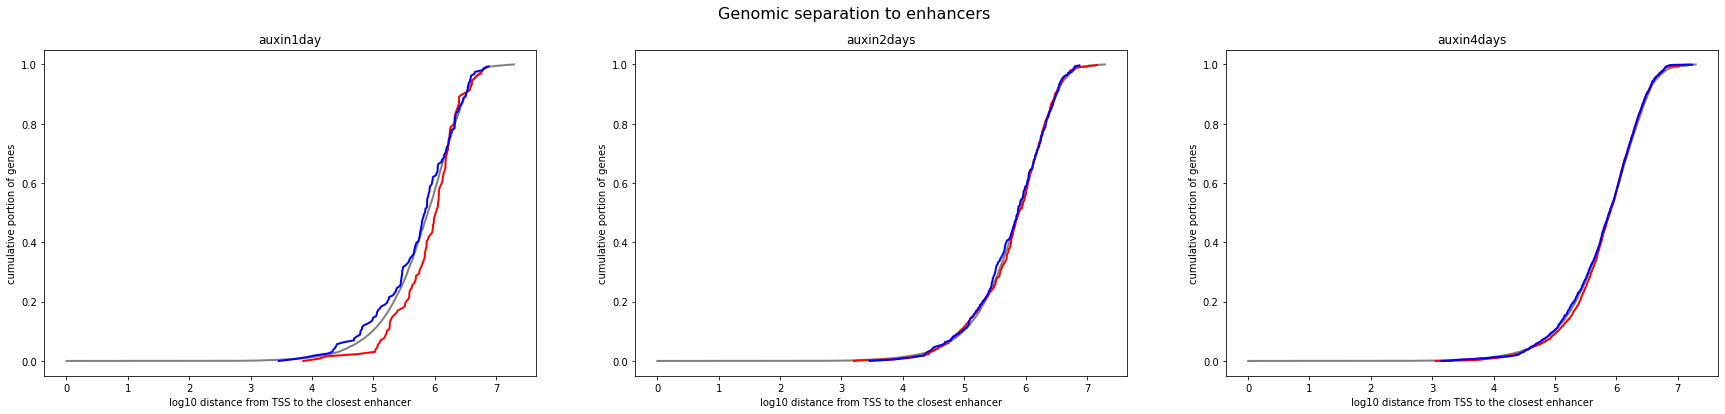

In [19]:
# Only plotting the change/distance to coordinates for DE results that are 1. AID-tagged and 2. have had some auxin treatment
only_treatment_results = [x for x in list(basic_deseq_results.keys()) if 'CTCF_AID_auxin' in x] 

# Generating a subplot for each of the conditions
num_plots = len(only_treatment_results)
fig, axs = plt.subplots(1, num_plots, figsize=[num_plots*10, 6])
fig.suptitle("Genomic separation to enhancers", fontsize=16)

# plot log10 distance between TSS and closest enhancers, color-coded by up-regulated/down-regulated or non-regulated genes
for condition, ax in zip(only_treatment_results, axs.ravel()):
    
    # adding TSS coordinates for the DEseq results
    tss_deseq_res = basic_deseq_results[condition].merge(tss_df.drop_duplicates(['gene_id']),
                                                         how='inner',
                                                         on='gene_id')
    
    # Using bioframe to find distance between TSS and closest enhancer
    closest_intervals = bf.closest(tss_deseq_res, enhancer_coords, suffixes=('_de_tss','_enhancer'))
    tss_deseq_res['distance_to_enhancer'] = closest_intervals['distance'].replace(0,1)
    
    # Dropping invalid distance_to_enhancer values
    tss_deseq_res.dropna(subset='distance_to_enhancer', inplace=True)
    
    # Filtering by significant (padj<0.5) --> separate by up-regulated and down-regulated
    up_ix = np.where((tss_deseq_res['padj'] < 0.05) & (tss_deseq_res['log2FoldChange'] > 0))
    down_ix = np.where((tss_deseq_res['padj'] < 0.05) & (tss_deseq_res['log2FoldChange'] < 0))
    nonsig_ix = np.where(tss_deseq_res['padj'] >= 0.05)
    
    # Getting the sets of genes
    up_reg_genes = tss_deseq_res.iloc[up_ix]
    down_reg_genes = tss_deseq_res.iloc[down_ix]
    nonsig_genes = tss_deseq_res.iloc[nonsig_ix]
    
    # Changing these values where distance between enhancer and tss is 0 to 1 (still close together)
    tss_deseq_res.loc[tss_deseq_res['distance_to_enhancer'] == 0, 'distance_to_enhancer'] = 1
    
    # generate y axis: cumulative proportion of genes
    cum_all = np.arange(0, len(tss_deseq_res.iloc[nonsig_ix]), 1)
    cum_all = cum_all/ len(tss_deseq_res.iloc[nonsig_ix])

    # plotting 
    ax.plot(np.log10(tss_deseq_res.iloc[nonsig_ix]['distance_to_enhancer'].sort_values()), 
                cum_all, 
                color='grey',
                label='Non-regulated',
                linewidth=2)


    # generate y axis: cumulative proportion of genes
    cum_up = np.arange(0, len(tss_deseq_res.iloc[up_ix]), 1)
    cum_up = cum_up/ len(tss_deseq_res.iloc[up_ix])

    ax.plot(np.log10(tss_deseq_res.iloc[up_ix]['distance_to_enhancer'].sort_values()), 
                cum_up, 
                color='red', 
                label='Up-regulated',
                linewidth=2)

    # generate y axis: cumulative proportion of genes
    cum_down = np.arange(0, len(tss_deseq_res.iloc[down_ix]), 1)
    cum_down = cum_down/ len(tss_deseq_res.iloc[down_ix])

    ax.plot(np.log10(tss_deseq_res.iloc[down_ix]['distance_to_enhancer'].sort_values()),
                cum_down,
                color='blue',
                label='Down-regulated',
                linewidth=2)
    
    ax.set_title(condition.replace("CTCF_AID_", ""))
    ax.set_xlabel("log10 distance from TSS to the closest enhancer")
    ax.set_ylabel("cumulative portion of genes")
    
    # Printing the raw number of significantly DE genes, for reference  
    print("=================")
    print("For condition {}, there are {} DE genes out of {} total (that have a mappable TSS)".format(condition, 
                                                                                                      len(up_reg_genes) + len(down_reg_genes), 
                                                                                                      len(tss_deseq_res)))
    print("Number of up-regulated genes: {}".format(len(up_reg_genes)))
    print("Number of down-regulated genes: {}".format(len(down_reg_genes)))
    print()
    
plt.show()

# Variation 2: DEG's from Nora 2017 supplementary table

## Detour: extracting TSS compatible with original genome build used in STAR alignment

Found that RefSeq archives are likely most compatible with the data set in supplementary table 11. We have two download choices:
1. `/project/fudenber_735/genomes/mm9/RefSeq/mm9.refGene.gtf` from hgdownload.cse.ucsc.edu/goldenPath/mm9/bigZips/
2. `/project/fudenber_735/genomes/mm9/gencode/gencode.vM1.annotation.gtf.gz` from https://www.gencodegenes.org/mouse/release_M1.html 

Going to 1. see how many have TSSes annotated already, 2. Compare the approximate range to the locus in the supplementary table file (might not be possible for some since they're annotated exons instead of genes. Maybe gffutils can help with this 3. use gff utils to extract a singe TSS for each tracking_id and add it to the dataset

In [20]:
import gffutils
import pybedtools
from pybedtools.featurefuncs import TSS
from gffutils.helpers import asinterval
import bioframe as bf
from gtfparse import read_gtf

In [21]:
refGene_df = pd.read_table("/project/fudenber_735/genomes/mm9/RefSeq/mm9.refGene.gtf", header=None, 
                          names=['seqname', 'type', 'feature', 'start', 'end', 'score', 'strand', 'frame',
                                'attributes'])

In [22]:
print("Number of transcript entries in refGene annotation file? " + str(len(refGene_df[refGene_df['feature'] == 'transcript'])))

Number of transcript entries in refGene annotation file? 44308


In [23]:
refGene_df['attributes'][0].split(";")[0:3]

['gene_id "Rbfox2"', ' transcript_id "NM_001110827"', '  gene_name "Rbfox2"']

In [24]:
# parses the string list of attributes from gtf file into a list
def split_ensembl_atts(attributeString):
    
    groups = attributeString.split(";")[0:3]
    data = [x.split('"')[1].strip() for x in groups]
    labels = [x.split('"')[0].strip() for x in groups]

    return data

In [25]:
attributes_listed =  [split_ensembl_atts(line) for line in refGene_df['attributes']]

attribute_df = pd.DataFrame(attributes_listed, columns =['gene_id', 'transcript_id', 'gene_name'])

refGene_df = pd.concat([refGene_df, attribute_df], axis=1)

In [26]:
refGene_df.head(3)

,seqname,type,feature,start,end,score,strand,frame,attributes,gene_id,transcript_id,gene_name
0,chr15,refGene,transcript,76909420,77137483,.,-,.,"gene_id ""Rbfox2""; transcript_id ""NM_001110827""...",Rbfox2,NM_001110827,Rbfox2
1,chr15,refGene,exon,76909420,76914636,.,-,.,"gene_id ""Rbfox2""; transcript_id ""NM_001110827""...",Rbfox2,NM_001110827,1
2,chr15,refGene,3UTR,76909420,76914591,.,-,.,"gene_id ""Rbfox2""; transcript_id ""NM_001110827""...",Rbfox2,NM_001110827,1


In [27]:
## Run this once, to generate db from gtf file
# db = gffutils.create_db("/project/fudenber_735/genomes/mm9/RefSeq/mm9.refGene.gtf", 
#                         "/project/fudenber_735/genomes/mm9/RefSeq/mm9.refGene.gtf.db", 
#                         force=True,
#                         disable_infer_transcripts=True)

refGene_db = gffutils.FeatureDB("/project/fudenber_735/genomes/mm9/RefSeq/mm9.refGene.gtf.db")

In [28]:
filename = '/project/fudenber_735/genomes/mm9/RefSeq/mm9.refGene.gtf'

filename.split('/')

['', 'project', 'fudenber_735', 'genomes', 'mm9', 'RefSeq', 'mm9.refGene.gtf']

In [5]:
def tss_generator():
    """
    Generator function to yield TSS of each annotated transcript
    """
    for transcript in refGene_db.features_of_type('transcript'):
        yield TSS(asinterval(transcript), upstream=1, downstream=0)

tsses = pybedtools.BedTool(tss_generator()).saveas('/project/fudenber_735/genomes/mm9/RefSeq/tsses_from_mm9.refGene.gtf')

In [29]:
refseq_tss_df = read_gtf('/project/fudenber_735/genomes/mm9/RefSeq/tsses_from_mm9.refGene.gtf')

print("Number of transcript entries in refGene annotation file? " + str(len(refGene_df[refGene_df['feature'] == 'transcript'])))
print("Number of transcript entries in gff utils generated tss annotation file: " + str(refseq_tss_df.shape[0]))

/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_name']


Number of transcript entries in refGene annotation file? 44308
Number of transcript entries in gff utils generated tss annotation file: 44308


In [30]:
refseq_tss_df.head(6)

,seqname,source,feature,start,end,score,strand,frame,gene_id,transcript_id,gene_name
0,chr15,refGene,transcript,77137484,77137484,NaN,-,0,Rbfox2,NM_001110827,Rbfox2
1,chr2,refGene,transcript,104334647,104334647,NaN,-,0,Hipk3,NM_001145824,Hipk3
2,chr2,refGene,transcript,11423718,11423718,NaN,-,0,Pfkfb3,NM_001177756,Pfkfb3
3,chr2,refGene,transcript,57090088,57090088,NaN,+,0,Gpd2,NM_001145820,Gpd2
4,chr6,refGene,transcript,135317510,135317510,NaN,+,0,Emp1,NM_001288627,Emp1
5,chr10,refGene,transcript,79389787,79389787,NaN,+,0,Arid3a,NM_001288626,Arid3a


In [31]:
# Add TSSes pulled from RefSeq db 
fpkm_refseq = fpkm.merge(refseq_tss_df.drop_duplicates('gene_name'), how='left', left_on='tracking_id', right_on='gene_name')
fpkm_refseq.head(10)

,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,...,source,feature,start,end,score,strand,frame,gene_id,transcript_id,gene_name
0,0610005C13Rik,chr7:52823164-52845080,0.784511,0.804255,1.040841,2.176798,1.209881,no,no,no,...,refGene,transcript,52830547.0,52830547.0,NaN,-,0,0610005C13Rik,NR_038165,0610005C13Rik
1,0610007P14Rik,chr12:87156404-87165495,71.716133,74.856200,63.412767,59.250033,67.995733,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,...,refGene,transcript,51502137.0,51502137.0,NaN,-,0,0610009B22Rik,NM_025319,0610009B22Rik
3,0610009L18Rik,chr11:120209991-120212504,0.944842,1.154941,0.905838,1.097459,0.889548,no,no,no,...,refGene,transcript,120209991.0,120209991.0,NaN,+,0,0610009L18Rik,NR_038126,0610009L18Rik
4,0610009O20Rik,chr18:38398058-38422283,17.565900,20.652933,20.476800,20.633733,18.857300,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0610010B08Rik,chr2:174952492-175261278,0.057933,0.051192,0.080296,0.091421,0.090390,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0610010F05Rik,chr11:23473775-23533631,4.500230,4.654253,3.784197,3.342397,4.257007,no,no,no,...,refGene,transcript,23533632.0,23533632.0,NaN,-,0,0610010F05Rik,NR_156450,0610010F05Rik
7,0610010K14Rik,chr11:70048705-70051416,115.794100,134.728000,124.419633,109.027433,95.227500,no,no,no,...,refGene,transcript,70051417.0,70051417.0,NaN,-,0,0610010K14Rik,NM_001177607,0610010K14Rik
8,0610011F06Rik,chr17:26012444-26014108,12.449400,12.249967,11.492490,12.151867,11.099847,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0610012G03Rik,chr16:31947136-31948607,34.492833,40.396067,36.419533,30.946500,30.611233,no,no,no,...,refGene,transcript,31948592.0,31948592.0,NaN,-,0,0610012G03Rik,NM_134107,0610012G03Rik


In [32]:
# Checking shapes and dimensions to make sure everything made it into the  
print(fpkm.shape[0])
print(fpkm_refseq.shape[0])

print("Number of entries that did not have a TSS entry in refseq annotations: ")
print(fpkm_refseq[fpkm_refseq['gene_id'].isna()].shape[0])

24315
24315
Number of entries that did not have a TSS entry in refseq annotations: 
1063


### Again, with gencode db

In [118]:
# # Generating database for Gencode (repeating same as above) -- MOVE TO SEPARATE HEADER TOO CONFUSING mixed in liket this
# gencode_db = gffutils.create_db("/project/fudenber_735/genomes/mm9/gencode/gencode.vM1.annotation.gtf.gz", 
#                         "/project/fudenber_735/genomes/mm9/gencode/gencode.vM1.annotation.gtf.db", 
#                         force=True)

In [143]:
def tss_generator():
    """
    Generator function to yield TSS of each annotated transcript
    """
    for transcript in gencode_db.features_of_type('transcript'):
        yield TSS(asinterval(transcript), upstream=1, downstream=0)

tsses = pybedtools.BedTool(tss_generator()).saveas('/project/fudenber_735/genomes/mm9/gencode/tsses_from_gencode.vM1.annotation.gtf')



KeyboardInterrupt: 

In [33]:
gencode_df = read_gtf("/project/fudenber_735/genomes/mm9/gencode/gencode.vM1.annotation.gtf.gz")

gencode_tss_df = read_gtf('/project/fudenber_735/genomes/mm9/gencode/tsses_from_gencode.vM1.annotation.gtf')

print("Number of transcript entries in refGene annotation file? " + str(len(gencode_df[gencode_df['feature'] == 'transcript'])))
print("Number of transcript entries in gff utils generated tss annotation file: " + str(gencode_tss_df.shape[0]))

/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_status', 'gene_name', 'transcript_type', 'transcript_status', 'transcript_name', 'level', 'havana_gene', 'ont', 'havana_transcript', 'exon_number', 'exon_id', 'tag', 'ccdsid']
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.



Number of transcript entries in refGene annotation file? 95495
Number of transcript entries in gff utils generated tss annotation file: 73915


In [34]:
print("Number of transcript entries in gencode annotation file? " + str(len(gencode_df[gencode_df['feature'] == 'transcript'])))

Number of transcript entries in gencode annotation file? 95495


In [80]:
# Add TSSes pulled from RefSeq db 
fpkm_gencode = fpkm.merge(refseq_tss_df.drop_duplicates('gene_name'), how='left', left_on='tracking_id', right_on='gene_name')
print(fpkm_gencode.columns)
fpkm_gencode.head(10)

Index(['tracking_id', 'locus', 'CTCF-AID_untreated_mean_FPKM',
       'CTCF-AID_1day_mean_FPKM', 'CTCF-AID_2days_mean_FPKM',
       'CTCF-AID_4days_mean_FPKM', 'CTCF-AID_washoff_mean_FPKM', '1day.1',
       '2days.1', '4days.1', '2days_washoff_2days.1', 'WT_untreated_mean_FPKM',
       'WT_2days_mean_FPKM', 'WT_4days_mean_FPKM', 'seqname', 'source',
       'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id',
       'transcript_id', 'gene_name'],
      dtype='object')


,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,...,source,feature,start,end,score,strand,frame,gene_id,transcript_id,gene_name
0,0610005C13Rik,chr7:52823164-52845080,0.784511,0.804255,1.040841,2.176798,1.209881,no,no,no,...,refGene,transcript,52830547.0,52830547.0,NaN,-,0,0610005C13Rik,NR_038165,0610005C13Rik
1,0610007P14Rik,chr12:87156404-87165495,71.716133,74.856200,63.412767,59.250033,67.995733,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,...,refGene,transcript,51502137.0,51502137.0,NaN,-,0,0610009B22Rik,NM_025319,0610009B22Rik
3,0610009L18Rik,chr11:120209991-120212504,0.944842,1.154941,0.905838,1.097459,0.889548,no,no,no,...,refGene,transcript,120209991.0,120209991.0,NaN,+,0,0610009L18Rik,NR_038126,0610009L18Rik
4,0610009O20Rik,chr18:38398058-38422283,17.565900,20.652933,20.476800,20.633733,18.857300,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0610010B08Rik,chr2:174952492-175261278,0.057933,0.051192,0.080296,0.091421,0.090390,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0610010F05Rik,chr11:23473775-23533631,4.500230,4.654253,3.784197,3.342397,4.257007,no,no,no,...,refGene,transcript,23533632.0,23533632.0,NaN,-,0,0610010F05Rik,NR_156450,0610010F05Rik
7,0610010K14Rik,chr11:70048705-70051416,115.794100,134.728000,124.419633,109.027433,95.227500,no,no,no,...,refGene,transcript,70051417.0,70051417.0,NaN,-,0,0610010K14Rik,NM_001177607,0610010K14Rik
8,0610011F06Rik,chr17:26012444-26014108,12.449400,12.249967,11.492490,12.151867,11.099847,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0610012G03Rik,chr16:31947136-31948607,34.492833,40.396067,36.419533,30.946500,30.611233,no,no,no,...,refGene,transcript,31948592.0,31948592.0,NaN,-,0,0610012G03Rik,NM_134107,0610012G03Rik


In [83]:
(fpkm_gencode['gene_id'] == fpkm_gencode['gene_name']).value_counts()

Series([], dtype: int64)

In [36]:
# Looking for unfound gene_ids 
print(fpkm.shape[0])
print(fpkm_gencode.shape[0])

print("Number of entries that did not have a TSS entry in Gencode annotations: ")
print(fpkm_gencode[fpkm_gencode['gene_id'].isna()].shape[0])

24315
24315
Number of entries that did not have a TSS entry in Gencode annotations: 
1063


In [86]:
# comparing annotations from the two, since appears to be the same number
(fpkm_gencode['gene_id'] == fpkm_refseq['gene_name']).value_counts()

True     23252
False     1063
dtype: int64

In [38]:
# Check if the TSS index annotated are the same
match_ix = np.where(fpkm_gencode['gene_id'] == fpkm_refseq['gene_id'])

(fpkm_gencode.loc[match_ix]['start'] == fpkm_refseq.loc[match_ix]['start']).value_counts()

True    23252
Name: start, dtype: int64

In [40]:
# Checking to see if any of the gene_ids which didn't have an annotated transcript exists in another form in the annotation
fpkm_gencode[fpkm_gencode['gene_id'].isna()].head(3)

,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,...,source,feature,start,end,score,strand,frame,gene_id,transcript_id,gene_name
1,0610007P14Rik,chr12:87156404-87165495,71.716133,74.856200,63.412767,59.250033,67.995733,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0610009O20Rik,chr18:38398058-38422283,17.565900,20.652933,20.476800,20.633733,18.857300,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0610010B08Rik,chr2:174952492-175261278,0.057933,0.051192,0.080296,0.091421,0.090390,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
unlabeled_id = fpkm_gencode[fpkm_gencode['gene_id'].isna()].iloc[0]['tracking_id']

print("Searching Gencode annotation GTF for: " + str(unlabeled_id))
## gencode_df.apply(lambda row: row.astype(str).str.contains(unlabeled_id).any(), axis=1)
print("Stopped search in pandas --> but grep returned multiple entries for this gene id??")

Searching Gencode annotation GTF for: 0610007P14Rik
Stopped search in pandas --> but grep returned multiple entries for this gene id??


My guess for missing values: either the gencode

In [42]:
gencode_orig_tsses = gencode_df[gencode_df['feature'] == 'start_codon']

In [43]:
print(gencode_orig_tsses.shape[0])
print(gencode_orig_tsses['gene_name'].head(3))
gencode_orig_tsses.head(10)

50189
16    Xkr4
39     Rp1
52     Rp1
Name: gene_name, dtype: object


,seqname,source,feature,start,end,score,strand,frame,gene_id,transcript_id,...,transcript_status,transcript_name,level,havana_gene,ont,havana_transcript,exon_number,exon_id,tag,ccdsid
16,chr1,HAVANA,start_codon,3661427,3661429,NaN,-,0,ENSMUSG00000051951.5,ENSMUST00000070533.4,...,KNOWN,Xkr4-001,2,OTTMUSG00000026353.2,,OTTMUST00000065166.1,1,ENSMUSE00000485541.3,"basic,CCDS",CCDS14803.1
39,chr1,ENSEMBL,start_codon,4342904,4342906,NaN,-,0,ENSMUSG00000025900.4,ENSMUST00000027032.3,...,KNOWN,Rp1-201,3,,,,2,ENSMUSE00000232073.3,"basic,CCDS",CCDS14804.1
52,chr1,ENSEMBL,start_codon,4342904,4342906,NaN,-,0,ENSMUSG00000025900.4,ENSMUST00000115540.1,...,KNOWN,Rp1-202,3,,,,2,ENSMUSE00000232073.3,basic,
68,chr1,ENSEMBL,start_codon,4483485,4483487,NaN,-,0,ENSMUSG00000025902.7,ENSMUST00000027035.3,...,KNOWN,Sox17-201,3,,,,4,ENSMUSE00000154039.3,"basic,CCDS",CCDS14805.1
82,chr1,ENSEMBL,start_codon,4483485,4483487,NaN,-,0,ENSMUSG00000025902.7,ENSMUST00000116652.2,...,KNOWN,Sox17-202,3,,,,3,ENSMUSE00000878088.1,"basic,CCDS",CCDS14805.1
100,chr1,HAVANA,start_codon,4775756,4775758,NaN,-,0,ENSMUSG00000033845.7,ENSMUST00000130201.1,...,KNOWN,Mrpl15-002,2,OTTMUSG00000029329.1,,OTTMUST00000072660.1,1,ENSMUSE00000450421.7,"basic,CCDS",CCDS35504.1
115,chr1,HAVANA,start_codon,4775756,4775758,NaN,-,0,ENSMUSG00000033845.7,ENSMUST00000156816.1,...,KNOWN,Mrpl15-001,2,OTTMUSG00000029329.1,,OTTMUST00000072659.1,1,ENSMUSE00000931984.1,"basic,CCDS",CCDS48211.1
130,chr1,HAVANA,start_codon,4775756,4775758,NaN,-,0,ENSMUSG00000033845.7,ENSMUST00000045689.7,...,KNOWN,Mrpl15-003,2,OTTMUSG00000029329.1,,OTTMUST00000072661.1,1,ENSMUSE00000789568.1,,
179,chr1,HAVANA,start_codon,4797995,4797997,NaN,+,0,ENSMUSG00000025903.8,ENSMUST00000027036.4,...,KNOWN,Lypla1-001,2,OTTMUSG00000021562.1,,OTTMUST00000051162.1,1,ENSMUSE00000792454.1,"basic,CCDS",CCDS14806.1
231,chr1,HAVANA,start_codon,4797995,4797997,NaN,+,0,ENSMUSG00000025903.8,ENSMUST00000137887.1,...,NOVEL,Lypla1-007,2,OTTMUSG00000021562.1,,OTTMUST00000051168.1,1,ENSMUSE00000805214.1,"mRNA_end_NF,cds_end_NF",


In [61]:
# Try labelling FPKM data with just the already annotated TSSes
fpkm_orig_gencode = fpkm.merge(gencode_orig_tsses.drop_duplicates('gene_name'), how='left', left_on='tracking_id', right_on='gene_name')
                               
print(fpkm_orig_gencode.columns)
fpkm_orig_gencode.head(10)

Index(['tracking_id', 'locus', 'CTCF-AID_untreated_mean_FPKM',
       'CTCF-AID_1day_mean_FPKM', 'CTCF-AID_2days_mean_FPKM',
       'CTCF-AID_4days_mean_FPKM', 'CTCF-AID_washoff_mean_FPKM', '1day.1',
       '2days.1', '4days.1', '2days_washoff_2days.1', 'WT_untreated_mean_FPKM',
       'WT_2days_mean_FPKM', 'WT_4days_mean_FPKM', 'seqname', 'source',
       'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id',
       'transcript_id', 'gene_type', 'gene_status', 'gene_name',
       'transcript_type', 'transcript_status', 'transcript_name', 'level',
       'havana_gene', 'ont', 'havana_transcript', 'exon_number', 'exon_id',
       'tag', 'ccdsid'],
      dtype='object')


,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,...,transcript_status,transcript_name,level,havana_gene,ont,havana_transcript,exon_number,exon_id,tag,ccdsid
0,0610005C13Rik,chr7:52823164-52845080,0.784511,0.804255,1.040841,2.176798,1.209881,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0610007P14Rik,chr12:87156404-87165495,71.716133,74.856200,63.412767,59.250033,67.995733,no,no,no,...,KNOWN,0610007P14Rik-001,2,OTTMUSG00000032571.1,,OTTMUST00000081014.1,2,ENSMUSE00000295744.3,"basic,CCDS",CCDS26063.1
2,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,...,KNOWN,0610009B22Rik-001,2,OTTMUSG00000005608.1,,OTTMUST00000012478.1,2,ENSMUSE00000679023.1,"basic,CCDS",CCDS36149.1
3,0610009L18Rik,chr11:120209991-120212504,0.944842,1.154941,0.905838,1.097459,0.889548,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0610009O20Rik,chr18:38398058-38422283,17.565900,20.652933,20.476800,20.633733,18.857300,no,no,no,...,KNOWN,0610009O20Rik-201,3,,,,1,ENSMUSE00000269236.4,"basic,CCDS",CCDS50260.1
5,0610010B08Rik,chr2:174952492-175261278,0.057933,0.051192,0.080296,0.091421,0.090390,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0610010F05Rik,chr11:23473775-23533631,4.500230,4.654253,3.784197,3.342397,4.257007,no,no,no,...,KNOWN,0610010F05Rik-003,2,OTTMUSG00000005276.2,,OTTMUST00000011758.2,1,ENSMUSE00000934484.1,"basic,CCDS",CCDS36119.1
7,0610010K14Rik,chr11:70048705-70051416,115.794100,134.728000,124.419633,109.027433,95.227500,no,no,no,...,NOVEL,0610010K14Rik-005,2,OTTMUSG00000006039.2,,OTTMUST00000013588.1,1,ENSMUSE00000458761.4,"basic,CCDS",CCDS48831.1
8,0610011F06Rik,chr17:26012444-26014108,12.449400,12.249967,11.492490,12.151867,11.099847,no,no,no,...,KNOWN,0610011F06Rik-005,2,OTTMUSG00000035873.2,,OTTMUST00000091993.1,1,ENSMUSE00000916485.1,,
9,0610012G03Rik,chr16:31947136-31948607,34.492833,40.396067,36.419533,30.946500,30.611233,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
print(fpkm.shape[0])
print(fpkm_orig_gencode.shape[0])

print("Number of entries that did not have a TSS entry annotated gencode start_codon: ")
print(fpkm_orig_gencode[fpkm_orig_gencode['gene_id'].isna()].shape[0])

24315
24315
Number of entries that did not have a TSS entry annotated gencode start_codon: 
5305


This is missing way more --> will go with the gffutils generated TSSes

Perhaps we can merge them?


In [63]:
# Comparing annotated gencode start_codons with gff_utils generated TSSes

print("How many did not have a gene ID in either TSS set?")
missing_ix = np.where(fpkm_orig_gencode['gene_name'].isna() & fpkm_gencode['gene_id'].isna())

fpkm_orig_gencode.loc[missing_ix]

How many did not have a gene ID in either TSS set?


,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,...,transcript_status,transcript_name,level,havana_gene,ont,havana_transcript,exon_number,exon_id,tag,ccdsid
5,0610010B08Rik,chr2:174952492-175261278,0.057933,0.051192,0.080296,0.091421,0.090390,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,1010001N08Rik,chr18:11042034-11085633,0.968879,1.514376,1.701958,3.042223,1.917330,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,1190002F15Rik,chr6:134879109-134901736,12.463803,13.283183,9.771923,5.705407,11.291177,no,no,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,1190003K10Rik,chr13:64582553-64599100,0.010722,0.010000,0.010000,0.013394,0.010000,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,1500011K16Rik,chr2:127617113-127618224,51.659667,63.654233,53.027700,33.302900,41.839033,no,no,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23085,Vmn1r207-ps,chr13:22817552-22818491,0.010000,0.010000,0.010000,0.010000,0.020214,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23396,Vwa9,chr9:64808638-64834788,16.963900,18.241167,16.307667,14.447500,16.970300,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23411,Wash1,chr17:66460885-66469843,11.520233,13.488233,14.300033,15.053533,12.177333,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23680,Zak,chr2:72123693-72280667,3.417830,2.966437,4.427577,5.465733,4.726070,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
fpkm_gencode['gene_name']

0        0610005C13Rik
1                  NaN
2        0610009B22Rik
3        0610009L18Rik
4                  NaN
             ...      
24310              Zyx
24311            Zzef1
24312             Zzz3
24313                a
24314              NaN
Name: gene_name, Length: 24315, dtype: object

In [65]:
fpkm_orig_gencode['gene_name']

0                  NaN
1        0610007P14Rik
2        0610009B22Rik
3                  NaN
4        0610009O20Rik
             ...      
24310              Zyx
24311            Zzef1
24312             Zzz3
24313                a
24314            l7Rn6
Name: gene_name, Length: 24315, dtype: object

In [87]:
fpkm_gencode[['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_name']] = \
    fpkm_gencode[['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_name']].fillna(
        fpkm_orig_gencode[['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_name']])

In [88]:
fpkm_gencode[fpkm_gencode['gene_name'].isna()].shape[0]

227

In [89]:
fpkm_gencode

,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,...,source,feature,start,end,score,strand,frame,gene_id,transcript_id,gene_name
0,0610005C13Rik,chr7:52823164-52845080,0.784511,0.804255,1.040841,2.176798,1.209881,no,no,no,...,refGene,transcript,52830547.0,52830547.0,NaN,-,0,0610005C13Rik,NR_038165,0610005C13Rik
1,0610007P14Rik,chr12:87156404-87165495,71.716133,74.856200,63.412767,59.250033,67.995733,no,no,no,...,HAVANA,start_codon,87163168.0,87163170.0,NaN,-,0,NaN,NaN,0610007P14Rik
2,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,...,refGene,transcript,51502137.0,51502137.0,NaN,-,0,0610009B22Rik,NM_025319,0610009B22Rik
3,0610009L18Rik,chr11:120209991-120212504,0.944842,1.154941,0.905838,1.097459,0.889548,no,no,no,...,refGene,transcript,120209991.0,120209991.0,NaN,+,0,0610009L18Rik,NR_038126,0610009L18Rik
4,0610009O20Rik,chr18:38398058-38422283,17.565900,20.652933,20.476800,20.633733,18.857300,no,no,no,...,ENSEMBL,start_codon,38410023.0,38410025.0,NaN,+,0,NaN,NaN,0610009O20Rik
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24310,Zyx,chr6:42299826-42330557,8.531693,8.734813,11.727350,24.111000,11.359220,no,no,yes,...,refGene,transcript,42299826.0,42299826.0,NaN,+,0,Zyx,NM_001289619,Zyx
24311,Zzef1,chr11:72609727-72740622,2.597283,2.411157,2.507930,3.121180,2.856007,no,no,no,...,refGene,transcript,72609727.0,72609727.0,NaN,+,0,Zzef1,NM_001045536,Zzef1
24312,Zzz3,chr3:152058966-152344396,9.986867,8.012557,7.069317,8.471867,10.256167,no,no,no,...,refGene,transcript,152059647.0,152059647.0,NaN,+,0,Zzz3,NM_001287139,Zzz3
24313,a,chr2:154839305-154876748,0.087051,0.167859,0.370351,0.402713,0.090154,no,no,no,...,refGene,transcript,154839305.0,154839305.0,NaN,+,0,a,NM_015770,a


In [115]:
# Replace the Start codon indices with single values
ix_start_codons_fwd = np.where((fpkm_gencode['feature'] == 'start_codon') & (fpkm_gencode['strand'] == '+'))
ix_start_codons_rev = np.where((fpkm_gencode['feature'] == 'start_codon') & (fpkm_gencode['strand'] == '-'))


# Replace the end position of forward strands 
fpkm_gencode["end"].loc[ix_start_codons_fwd].replace(fpkm_gencode.loc[ix_start_codons_fwd]["start"])

fpkm_gencode["start"].loc[ix_start_codons_rev].replace(fpkm_gencode.loc[ix_start_codons_rev]["end"])

# Replace the start position of reverse strands 

fpkm_gencode.head(10)

,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,...,source,feature,start,end,score,strand,frame,gene_id,transcript_id,gene_name
0,0610005C13Rik,chr7:52823164-52845080,0.784511,0.804255,1.040841,2.176798,1.209881,no,no,no,...,refGene,transcript,52830547.0,52830547.0,NaN,-,0,0610005C13Rik,NR_038165,0610005C13Rik
1,0610007P14Rik,chr12:87156404-87165495,71.716133,74.856200,63.412767,59.250033,67.995733,no,no,no,...,HAVANA,start_codon,87163170.0,87163170.0,NaN,-,0,NaN,NaN,0610007P14Rik
2,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,...,refGene,transcript,51502137.0,51502137.0,NaN,-,0,0610009B22Rik,NM_025319,0610009B22Rik
3,0610009L18Rik,chr11:120209991-120212504,0.944842,1.154941,0.905838,1.097459,0.889548,no,no,no,...,refGene,transcript,120209991.0,120209991.0,NaN,+,0,0610009L18Rik,NR_038126,0610009L18Rik
4,0610009O20Rik,chr18:38398058-38422283,17.565900,20.652933,20.476800,20.633733,18.857300,no,no,no,...,ENSEMBL,start_codon,38410023.0,38410023.0,NaN,+,0,NaN,NaN,0610009O20Rik
5,0610010B08Rik,chr2:174952492-175261278,0.057933,0.051192,0.080296,0.091421,0.090390,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0610010F05Rik,chr11:23473775-23533631,4.500230,4.654253,3.784197,3.342397,4.257007,no,no,no,...,refGene,transcript,23533632.0,23533632.0,NaN,-,0,0610010F05Rik,NR_156450,0610010F05Rik
7,0610010K14Rik,chr11:70048705-70051416,115.794100,134.728000,124.419633,109.027433,95.227500,no,no,no,...,refGene,transcript,70051417.0,70051417.0,NaN,-,0,0610010K14Rik,NM_001177607,0610010K14Rik
8,0610011F06Rik,chr17:26012444-26014108,12.449400,12.249967,11.492490,12.151867,11.099847,no,no,no,...,HAVANA,start_codon,26012475.0,26012475.0,NaN,+,0,NaN,NaN,0610011F06Rik
9,0610012G03Rik,chr16:31947136-31948607,34.492833,40.396067,36.419533,30.946500,30.611233,no,no,no,...,refGene,transcript,31948592.0,31948592.0,NaN,-,0,0610012G03Rik,NM_134107,0610012G03Rik


## Replicating Figure 6(D) using Supplementary table

## Formatting and labelling supplementary table of DE results

In [116]:
# Reformatting to use bioframe operations

# dropping null entries (anything that didn't have a match in the TSS database
print("number of FPKM results before dropping null values: " + str(fpkm_gencode.shape[0]))
fpkm_gencode.dropna(subset=['gene_id'], inplace=True)
print("Size after dropping null values: " + str(fpkm_gencode.shape[0]))

fpkm_gencode = fpkm_gencode.rename(columns = {'seqname' : 'chrom'})

number of FPKM results before dropping null values: 24315
Size after dropping null values: 23252


In [117]:
fpkm_gencode.head(4)

,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,...,source,feature,start,end,score,strand,frame,gene_id,transcript_id,gene_name
0,0610005C13Rik,chr7:52823164-52845080,0.784511,0.804255,1.040841,2.176798,1.209881,no,no,no,...,refGene,transcript,52830547.0,52830547.0,NaN,-,0,0610005C13Rik,NR_038165,0610005C13Rik
2,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,...,refGene,transcript,51502137.0,51502137.0,NaN,-,0,0610009B22Rik,NM_025319,0610009B22Rik
3,0610009L18Rik,chr11:120209991-120212504,0.944842,1.154941,0.905838,1.097459,0.889548,no,no,no,...,refGene,transcript,120209991.0,120209991.0,NaN,+,0,0610009L18Rik,NR_038126,0610009L18Rik
6,0610010F05Rik,chr11:23473775-23533631,4.500230,4.654253,3.784197,3.342397,4.257007,no,no,no,...,refGene,transcript,23533632.0,23533632.0,NaN,-,0,0610010F05Rik,NR_156450,0610010F05Rik


In [120]:
fpkm_gencode = bf.sanitize_bedframe(fpkm_gencode)

bf.is_bedframe(fpkm_gencode)

True

In [121]:
# Get distance between TSSes and the closest enhancer
closest_intervals_nora = bf.closest(fpkm_gencode, enhancer_coords, suffixes=('_de_tss','_enhancer'))
fpkm['distance_to_enhancer'] = closest_intervals_nora['distance']

In [122]:
# How many?
print("Number of genes that have distance from TSS to enhancer = 0 is : " + str(len(fpkm[fpkm['distance_to_enhancer'] == 0]))) 

# Changing these values to = 1 
fpkm.loc[fpkm['distance_to_enhancer'] == 0, 'distance_to_enhancer'] = 1

# How many have no enhancer to call home
print("Number of genes that did not find a closest enhancer: " + str(len(fpkm[pd.isna(fpkm['distance_to_enhancer'])])))

Number of genes that have distance from TSS to enhancer = 0 is : 4
Number of genes that did not find a closest enhancer: 1150


In [124]:
fpkm.dropna(subset='distance_to_enhancer', inplace=True)

In [127]:
# Checking to make sure filter is on enhancer coords
enhancer_coords.tail(5)

,chrom,start,end,value
1272,chr18,77381001,77382000,0.8005
1273,chr9,78222001,78223000,0.8004
1274,chr1,138467001,138468000,0.8003
1275,chr14,12940001,12941000,0.8000
1276,chr2,135388001,135389000,0.8000


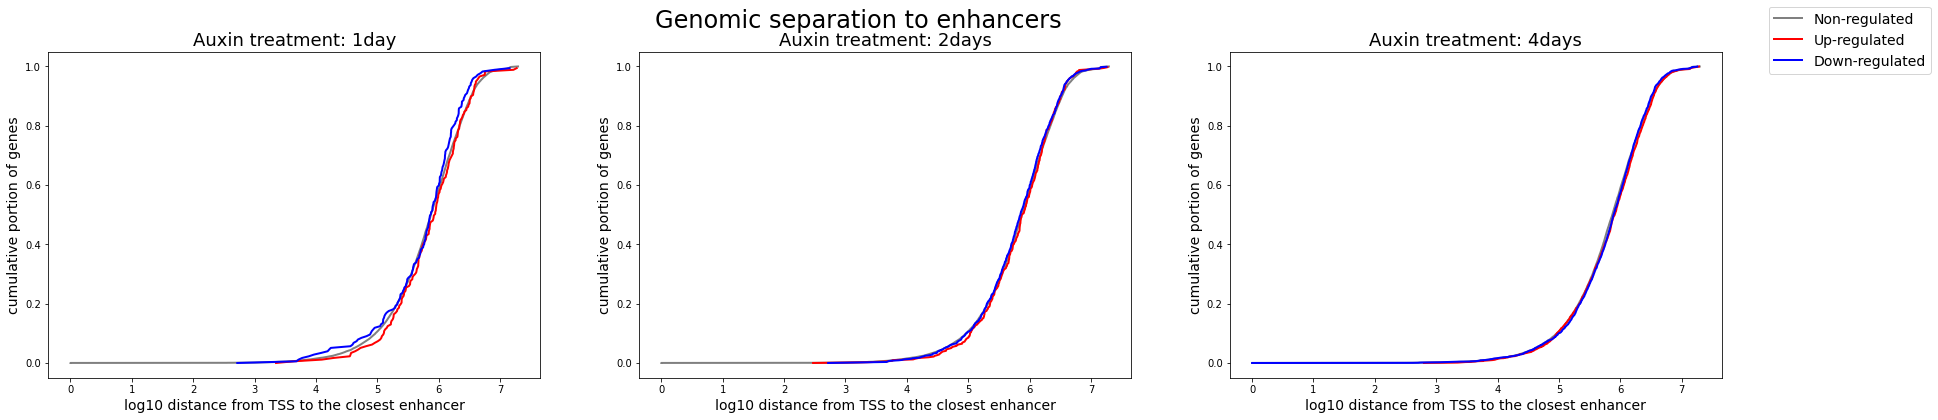

In [125]:
days = ['1day', '2days', '4days']

# Generating a subplot for each of the conditions
num_plots = len(days)
fig, axs = plt.subplots(1, num_plots, figsize=[num_plots*10, 6])
fig.suptitle("Genomic separation to enhancers", fontsize=24)

for day, ax in zip(days, axs.ravel()):
    
    up_reg = fpkm.iloc[np.where((fpkm[day + '.1'] == 'yes') & ((fpkm['CTCF-AID_untreated_mean_FPKM'] - fpkm['CTCF-AID_' + day + '_mean_FPKM']) > 0))]
    down_reg = fpkm.iloc[np.where((fpkm[day + '.1'] == 'yes') & ((fpkm['CTCF-AID_untreated_mean_FPKM'] - fpkm['CTCF-AID_' + day + '_mean_FPKM']) < 0))]
    non_reg = fpkm.iloc[np.where(fpkm[day + '.1'] == 'no')]
    
    # generate y axis: cumulative proportion of genes
    cum_all = np.arange(0, len(non_reg), 1)
    cum_all = cum_all/ len(non_reg)

    # plotting 
    ax.plot(np.log10(non_reg['distance_to_enhancer'].sort_values()), 
                cum_all, 
                color='grey',
                label='Non-regulated',
                linewidth=2)


    # generate y axis: cumulative proportion of genes
    cum_up = np.arange(0, len(up_reg), 1)
    cum_up = cum_up/ len(up_reg)

    ax.plot(np.log10(up_reg['distance_to_enhancer'].sort_values()), 
                cum_up, 
                color='red', 
                label='Up-regulated',
                linewidth=2)

    # generate y axis: cumulative proportion of genes
    cum_down = np.arange(0, len(down_reg), 1)
    cum_down = cum_down/ len(down_reg)

    ax.plot(np.log10(down_reg['distance_to_enhancer'].sort_values()),
                cum_down,
                color='blue',
                label='Down-regulated',
                linewidth=2)
    
    ax.set_title("Auxin treatment: " + day, fontsize=18)
    ax.set_xlabel("log10 distance from TSS to the closest enhancer", fontsize=14)
    ax.set_ylabel("cumulative portion of genes", fontsize=14)
    
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, fontsize=14)
plt.show()

### Unsuccessful method: matching tracking_id (MGI ids http://www.informatics.jax.org/) to ensembl ids

- Attempt using MRK_ENSEMBL.rpt downloaded from MGI website http://www.informatics.jax.org/downloads/reports/index.html
  - issues: no versioning associated?

In [132]:
# mold fpkm data to be more like the above

In [133]:
mgi_ensembl = pd.read_csv("/project/fudenber_735/genomes/mm9/ensembl/ensembl_relational_downloads/MRK_ENSEMBL.rpt", sep='\t', header=None)

In [134]:
print(mgi_ensembl.shape[0])
mgi_ensembl.head(3)

55341


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,MGI:1915733,1110002O04Rik,RIKEN cDNA 1110002O04 gene,-1.00,1,ENSMUSG00000102531,ENSMUST00000194261,NaN,lncRNA gene,35918926,35920200,+,ncRNA|lncRNA
1,MGI:1919275,1600012P17Rik,RIKEN cDNA 1600012P17 gene,68.49,1,ENSMUSG00000047661,ENSMUST00000062159 ENSMUST00000162474,NaN,lncRNA gene,158795271,158808032,-,lncRNA|ncRNA
2,MGI:1914753,1700001G17Rik,RIKEN cDNA 1700001G17 gene,12.78,1,ENSMUSG00000103746,NaN,NaN,lncRNA gene,33708905,33709793,+,TEC|ncRNA


In [135]:
# add column names
mgi_ensembl = mgi_ensembl.rename(columns={0 : 'mgi_id',
                            1 : 'mgi_gene',
                            2 : 'description',
                            3 : 'not_sure',
                            4 : 'chrom',
                            5 : 'ensembl_gene_id',
                            6 : 'ensembl_transcript_ids',
                            7 : 'ensembl_protein_id',
                            8 : 'biotype',
                            9 : 'start',
                            10 : 'end',
                            11 : 'strand',
                            12 : 'possible_biotypes'})

In [136]:
# first, mapping to deseq results to see compatibility/completeness of the two sets
print("number of unique id's in DEseq results (from kallisto mapping): " + str(basic_deseq_results['CTCF_AID_auxin1day']['gene_id'].nunique()))

basic_deseq_results['CTCF_AID_auxin1day'].merge(mgi_ensembl, how='left', left_on='gene_id', right_on='ensembl_gene_id')

number of unique id's in DEseq results (from kallisto mapping): 26520


,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,mgi_id,mgi_gene,description,not_sure,chrom,ensembl_gene_id,ensembl_transcript_ids,ensembl_protein_id,biotype,start,end,strand,possible_biotypes
0,ENSMUSG00000000001,4942.457855,-0.033551,0.236434,-0.141905,8.871554e-01,9.998054e-01,MGI:95773,Gnai3,guanine nucleotide binding protein (G protein)...,46.83,3,ENSMUSG00000000001,ENSMUST00000000001,ENSMUSP00000000001,protein coding gene,108014596.0,108053462.0,-,protein-coding|protein_coding
1,ENSMUSG00000000003,0.000000,NaN,NaN,NaN,NaN,NaN,MGI:1860484,Pbsn,probasin,38.32,X,ENSMUSG00000000003,ENSMUST00000000003 ENSMUST00000114041,ENSMUSP00000000003 ENSMUSP00000109675,protein coding gene,76881504.0,76897106.0,-,protein_coding|protein-coding
2,ENSMUSG00000000028,2278.335221,-0.091383,0.163252,-0.559764,5.756404e-01,9.998054e-01,MGI:1338073,Cdc45,cell division cycle 45,11.63,16,ENSMUSG00000000028,ENSMUST00000231819 ENSMUST00000096990 ENSMUST0...,ENSMUSP00000094753 ENSMUSP00000111248 ENSMUSP0...,protein coding gene,18599197.0,18630737.0,-,protein_coding|protein-coding
3,ENSMUSG00000000037,398.325060,2.463827,0.236823,10.403647,2.386216e-25,4.369956e-22,MGI:1340042,Scml2,Scm polycomb group protein like 2,73.95,X,ENSMUSG00000000037,ENSMUST00000238603 ENSMUST00000077375 ENSMUST0...,ENSMUSP00000076593 ENSMUSP00000019101 ENSMUSP0...,protein coding gene,159865521.0,160041209.0,+,protein-coding|protein_coding
4,ENSMUSG00000000049,0.000000,NaN,NaN,NaN,NaN,NaN,MGI:88058,Apoh,apolipoprotein H,71.80,11,ENSMUSG00000000049,ENSMUST00000152958 ENSMUST00000146050 ENSMUST0...,ENSMUSP00000123486 ENSMUSP00000114214 ENSMUSP0...,protein coding gene,108286123.0,108305222.0,+,protein_coding|protein-coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26516,ENSMUSG00000084412,0.000000,NaN,NaN,NaN,NaN,NaN,MGI:3651841,Gm12044,predicted gene 12044,13.89,11,ENSMUSG00000084412,ENSMUST00000120335,NaN,pseudogene,21401142.0,21401354.0,-,processed_pseudogene
26517,ENSMUSG00000084413,9.829391,1.454489,1.157044,1.257073,2.087272e-01,9.998054e-01,MGI:3651377,Gm12017,predicted gene 12017,10.45,11,ENSMUSG00000084413,ENSMUST00000122453,NaN,pseudogene,17923788.0,17924790.0,-,processed_pseudogene|pseudo
26518,ENSMUSG00000084414,0.060269,-0.698860,4.055402,-0.172328,8.631796e-01,NaN,MGI:3649599,Gm11270,predicted gene 11270,7.73,13,ENSMUSG00000084414,ENSMUST00000117685,NaN,pseudogene,21480418.0,21480888.0,-,pseudo|processed_pseudogene
26519,ENSMUSG00000084415,0.000000,NaN,NaN,NaN,NaN,NaN,MGI:3649425,Gm12837,predicted gene 12837,52.99,4,ENSMUSG00000084415,ENSMUST00000120131,NaN,pseudogene,115273279.0,115273651.0,-,pseudo|processed_pseudogene


In [137]:
result_df = basic_deseq_results['CTCF_AID_auxin1day'].copy()

# Let's add this label to our results dataset
result_df['mgi_gene'] = result_df.merge(mgi_ensembl, how='left', left_on='gene_id', right_on='ensembl_gene_id')['mgi_gene']

# count any that didn't have an mgi_gene match
result_df['mgi_gene'].isna().sum()

2537

In [138]:
result_df[result_df['mgi_gene'].isna()]

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,mgi_gene
59,ENSMUSG00000000325,1176.624728,0.139254,0.489379,0.284553,0.775987,0.999805,NaN
117,ENSMUSG00000000702,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
240,ENSMUSG00000001379,627.512892,-0.133893,0.172369,-0.776780,0.437289,0.999805,NaN
406,ENSMUSG00000002290,12.458554,0.148792,0.751600,0.197967,0.843071,0.999805,NaN
539,ENSMUSG00000003178,468.462225,-0.240071,0.199192,-1.205225,0.228117,0.999805,NaN
...,...,...,...,...,...,...,...,...
26502,ENSMUSG00000084399,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
26506,ENSMUSG00000084403,2.354672,-0.070210,1.486532,-0.047231,0.962329,NaN,NaN
26510,ENSMUSG00000084407,0.266680,1.835794,4.037416,0.454695,0.649329,NaN,NaN
26513,ENSMUSG00000084410,5.151212,1.207003,1.291019,0.934923,0.349828,0.999805,NaN


### Using MGI relationship table to add ensembl_id's to FPKM table (mapping mgi_id --> ensembl)

In [167]:
fpkm.merge(mgi_ensembl, how='left', left_on='tracking_id', right_on='mgi_gene')

,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,...,not_sure,chrom,ensembl_gene_id_y,ensembl_transcript_ids,ensembl_protein_id,biotype,start,end,strand,possible_biotypes
0,0610005C13Rik,chr7:52823164-52845080,0.784511,0.804255,1.040841,2.176798,1.209881,no,no,no,...,29.36,7,ENSMUSG00000109644,ENSMUST00000210965 ENSMUST00000209510 ENSMUST0...,NaN,lncRNA gene,45217219.0,45224600.0,-,ncRNA|lncRNA
1,0610007P14Rik,chr12:87156404-87165495,71.716133,74.856200,63.412767,59.250033,67.995733,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,...,31.26,11,ENSMUSG00000007777,ENSMUST00000007921 ENSMUST00000109098,ENSMUSP00000104726 ENSMUSP00000007921,protein coding gene,51576213.0,51579701.0,-,protein_coding|protein-coding
3,0610009L18Rik,chr11:120209991-120212504,0.944842,1.154941,0.905838,1.097459,0.889548,no,no,no,...,84.07,11,ENSMUSG00000043644,ENSMUST00000143813,NaN,lncRNA gene,120239504.0,120242016.0,+,ncRNA|lncRNA
4,0610009O20Rik,chr18:38398058-38422283,17.565900,20.652933,20.476800,20.633733,18.857300,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24343,Zyx,chr6:42299826-42330557,8.531693,8.734813,11.727350,24.111000,11.359220,no,no,yes,...,20.64,6,ENSMUSG00000029860,ENSMUST00000203401 ENSMUST00000204480 ENSMUST0...,ENSMUSP00000145236 ENSMUSP00000145052 ENSMUSP0...,protein coding gene,42326564.0,42337147.0,+,protein_coding|protein-coding
24344,Zzef1,chr11:72609727-72740622,2.597283,2.411157,2.507930,3.121180,2.856007,no,no,no,...,44.56,11,ENSMUSG00000055670,ENSMUST00000150551 ENSMUST00000145393 ENSMUST0...,ENSMUSP00000130515 ENSMUSP00000147028 ENSMUSP0...,protein coding gene,72687052.0,72817946.0,+,protein_coding|protein-coding
24345,Zzz3,chr3:152058966-152344396,9.986867,8.012557,7.069317,8.471867,10.256167,no,no,no,...,77.16,3,ENSMUSG00000039068,ENSMUST00000198468 ENSMUST00000089982 ENSMUST0...,ENSMUSP00000087428 ENSMUSP00000101709 ENSMUSP0...,protein coding gene,152101110.0,152168463.0,+,protein_coding|protein-coding
24346,a,chr2:154839305-154876748,0.087051,0.167859,0.370351,0.402713,0.090154,no,no,no,...,76.83,2,ENSMUSG00000027596,ENSMUST00000148402 ENSMUST00000109697 ENSMUST0...,ENSMUSP00000122261 ENSMUSP00000029123 ENSMUSP0...,protein coding gene,154792519.0,154892932.0,+,protein_coding|protein-coding


In [165]:
fpkm['ensembl_gene_id'] = fpkm.merge(mgi_ensembl, how='left', left_on='tracking_id', right_on='mgi_gene')['ensembl_gene_id']
fpkm.head(10)

,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,2days_washoff_2days.1,WT_untreated_mean_FPKM,WT_2days_mean_FPKM,WT_4days_mean_FPKM,ensembl_gene_id
0,0610005C13Rik,chr7:52823164-52845080,0.784511,0.804255,1.040841,2.176798,1.209881,no,no,no,no,0.531110,0.539697,0.414068,ENSMUSG00000109644
1,0610007P14Rik,chr12:87156404-87165495,71.716133,74.856200,63.412767,59.250033,67.995733,no,no,no,no,57.020867,49.716167,57.023633,NaN
2,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,no,58.497000,46.990267,58.072767,ENSMUSG00000007777
3,0610009L18Rik,chr11:120209991-120212504,0.944842,1.154941,0.905838,1.097459,0.889548,no,no,no,no,1.180704,1.977405,0.825640,ENSMUSG00000043644
4,0610009O20Rik,chr18:38398058-38422283,17.565900,20.652933,20.476800,20.633733,18.857300,no,no,no,no,18.864133,18.413433,18.779333,NaN
5,0610010B08Rik,chr2:174952492-175261278,0.057933,0.051192,0.080296,0.091421,0.090390,no,no,no,no,0.071852,0.105181,0.096969,NaN
6,0610010F05Rik,chr11:23473775-23533631,4.500230,4.654253,3.784197,3.342397,4.257007,no,no,no,no,4.556360,3.955583,4.441780,NaN
7,0610010K14Rik,chr11:70048705-70051416,115.794100,134.728000,124.419633,109.027433,95.227500,no,no,no,no,104.590300,129.307667,99.449367,ENSMUSG00000020831
8,0610011F06Rik,chr17:26012444-26014108,12.449400,12.249967,11.492490,12.151867,11.099847,no,no,no,no,10.334770,14.981610,11.079557,NaN
9,0610012G03Rik,chr16:31947136-31948607,34.492833,40.396067,36.419533,30.946500,30.611233,no,no,no,no,26.746667,35.935333,23.776233,ENSMUSG00000107002


In [166]:
# how many are missing
missing = fpkm['ensembl_gene_id'].isna().sum()
tot = fpkm.shape[0]

print("Out of {} genes labeled by mgi gene name in Nora results table, {} are missing a corresponding ensembl id, {}%.".format(tot, 
                                                                                                                               missing,
                                                                                                                               (float) (missing/tot) * 100))

Out of 24315 genes labeled by mgi gene name in Nora results table, 1562 are missing a corresponding ensembl id, 6.424018095825621%.


For the purposes of checking/verifying consistency, we'll just toss the un-matched ones. If things look really weird, find a better reference?

In [141]:
fpkm = fpkm.merge(tss_df.drop_duplicates(['gene_id']), how='inner', left_on='ensembl_gene_id', right_on='gene_id', suffixes=('_data', '_tss')) 

new_len = fpkm.shape[0]

print("Out of {} genes in results table, {} had a corresponding TSS (so {} were dropped)".format(tot, new_len, tot-new_len))

Out of 24315 genes in results table, 20188 had a corresponding TSS (so 4127 were dropped)


In [142]:
fpkm.head(5)

,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,...,chrom,source,feature,start,end,score,strand,frame,transcript_id,gene_id
0,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,...,chr11,gffutils_derived,transcript,51502156,51502156,NaN,-,0,ENSMUST00000007921,ENSMUSG00000007777
1,0610009L18Rik,chr11:120209991-120212504,0.944842,1.154941,0.905838,1.097459,0.889548,no,no,no,...,chr11,gffutils_derived,transcript,120209991,120209991,NaN,+,0,ENSMUST00000143813,ENSMUSG00000043644
2,0610010K14Rik,chr11:70048705-70051416,115.794100,134.728000,124.419633,109.027433,95.227500,no,no,no,...,chr11,gffutils_derived,transcript,70051417,70051417,NaN,-,0,ENSMUST00000021180,ENSMUSG00000020831
3,0610030E20Rik,chr6:72297310-72303154,3.961530,4.223233,4.699287,5.407897,4.271537,no,no,no,...,chr6,gffutils_derived,transcript,72297310,72297310,NaN,+,0,ENSMUST00000077783,ENSMUSG00000058706
4,0610039K10Rik,chr2:163449008-163471536,0.337451,0.253110,0.320109,0.318655,0.178876,no,no,no,...,chr2,gffutils_derived,transcript,163470585,163470585,NaN,+,0,ENSMUST00000076667,ENSMUSG00000058812


In [143]:
# Get distance between TSSes and the closest enhancer
closest_intervals_nora = bf.closest(fpkm, enhancer_coords, suffixes=('_de_tss','_enhancer'))
fpkm['distance_to_enhancer'] = closest_intervals_nora['distance']

In [144]:
fpkm

,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,...,source,feature,start,end,score,strand,frame,transcript_id,gene_id,distance_to_enhancer
0,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,...,gffutils_derived,transcript,51502156,51502156,NaN,-,0,ENSMUST00000007921,ENSMUSG00000007777,202016
1,0610009L18Rik,chr11:120209991-120212504,0.944842,1.154941,0.905838,1.097459,0.889548,no,no,no,...,gffutils_derived,transcript,120209991,120209991,NaN,+,0,ENSMUST00000143813,ENSMUSG00000043644,3158057
2,0610010K14Rik,chr11:70048705-70051416,115.794100,134.728000,124.419633,109.027433,95.227500,no,no,no,...,gffutils_derived,transcript,70051417,70051417,NaN,-,0,ENSMUST00000021180,ENSMUSG00000020831,233462
3,0610030E20Rik,chr6:72297310-72303154,3.961530,4.223233,4.699287,5.407897,4.271537,no,no,no,...,gffutils_derived,transcript,72297310,72297310,NaN,+,0,ENSMUST00000077783,ENSMUSG00000058706,312
4,0610039K10Rik,chr2:163449008-163471536,0.337451,0.253110,0.320109,0.318655,0.178876,no,no,no,...,gffutils_derived,transcript,163470585,163470585,NaN,+,0,ENSMUST00000076667,ENSMUSG00000058812,742451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20183,Zyx,chr6:42299826-42330557,8.531693,8.734813,11.727350,24.111000,11.359220,no,no,yes,...,gffutils_derived,transcript,23737822,23737822,NaN,+,0,ENSMUST00000095595,ENSMUSG00000023902,<NA>
20184,Zzef1,chr11:72609727-72740622,2.597283,2.411157,2.507930,3.121180,2.856007,no,no,no,...,gffutils_derived,transcript,21454695,21454695,NaN,+,0,ENSMUST00000053293,ENSMUSG00000036721,<NA>
20185,Zzz3,chr3:152058966-152344396,9.986867,8.012557,7.069317,8.471867,10.256167,no,no,no,...,gffutils_derived,transcript,13361008,13361008,NaN,-,0,ENSMUST00000046245,ENSMUSG00000070822,<NA>
20186,a,chr2:154839305-154876748,0.087051,0.167859,0.370351,0.402713,0.090154,no,no,no,...,gffutils_derived,transcript,88006993,88006993,NaN,+,0,ENSMUST00000044115,ENSMUSG00000038797,<NA>


In [145]:
# todo:

# assign TSSes to fpkm
# get distance between these TSSes and the enhancer data
# for each day condition:
    # filter for 'sig' by 1day.1, 2days.1, 4days.1
    # graph the distances, sorted in each of these three groups

In [146]:
up = fpkm.iloc[np.where((fpkm['1day.1'] == 'yes') & ((fpkm['CTCF-AID_untreated_mean_FPKM'] - fpkm['CTCF-AID_1day_mean_FPKM']) < 0))]
down = fpkm.iloc[np.where((fpkm['1day.1'] == 'yes') & ((fpkm['CTCF-AID_untreated_mean_FPKM'] - fpkm['CTCF-AID_1day_mean_FPKM']) > 0))]
non = fpkm.iloc[np.where(fpkm['1day.1'] == 'no')]

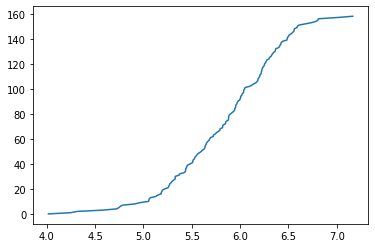

In [147]:
plt.plot(np.log10(up['distance_to_enhancer'].sort_values()), np.arange(0, len(up), 1))

In [152]:
# How many?
print("Number of genes that have distance from TSS to enhancer = 0 is : " + str(len(fpkm[fpkm['distance_to_enhancer'] == 0]))) 

# Changing these values to = 1 
fpkm.loc[fpkm['distance_to_enhancer'] == 0, 'distance_to_enhancer'] = 1

# How many have no enhancer to call home
print("Number of genes that did not find a closest enhancer: " + str(len(fpkm[pd.isna(fpkm['distance_to_enhancer'])])))

Number of genes that have distance from TSS to enhancer = 0 is : 0
Number of genes that did not find a closest enhancer: 10


In [153]:
# Interesting that these are similar number to the above -- going to print out the entries before dropping to compare
fpkm[pd.isna(fpkm['distance_to_enhancer'])]

,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,...,source,feature,start,end,score,strand,frame,transcript_id,gene_id,distance_to_enhancer
20178,Zxda,chrX:92036623-92043628,0.065962,0.127417,0.120941,0.171184,0.077726,no,no,no,...,gffutils_derived,transcript,140141266,140141266,NaN,+,0,ENSMUST00000033265,ENSMUSG00000030967,<NA>
20179,Zxdb,chrX:91969907-91975530,0.185390,0.117669,0.193258,0.247512,0.138311,no,no,no,...,gffutils_derived,transcript,157197322,157197322,NaN,+,0,ENSMUST00000029831,ENSMUSG00000028180,<NA>
20180,Zxdc,chr6:90319487-90353480,4.497293,4.802807,5.840457,6.868297,5.241337,no,no,yes,...,gffutils_derived,transcript,129999031,129999031,NaN,-,0,ENSMUST00000037426,ENSMUSG00000036086,<NA>
20181,Zyg11a,chr4:107854538-107890527,2.508323,3.991237,3.020370,3.450447,4.242610,no,no,no,...,gffutils_derived,transcript,22873214,22873214,NaN,+,0,ENSMUST00000049506,ENSMUSG00000044068,<NA>
20182,Zyg11b,chr4:107900359-107973695,4.213553,3.829030,3.525300,4.269620,4.373337,no,no,no,...,gffutils_derived,transcript,160396531,160396531,NaN,-,0,ENSMUST00000033736,ENSMUSG00000031370,<NA>
20183,Zyx,chr6:42299826-42330557,8.531693,8.734813,11.727350,24.111000,11.359220,no,no,yes,...,gffutils_derived,transcript,23737822,23737822,NaN,+,0,ENSMUST00000095595,ENSMUSG00000023902,<NA>
20184,Zzef1,chr11:72609727-72740622,2.597283,2.411157,2.507930,3.121180,2.856007,no,no,no,...,gffutils_derived,transcript,21454695,21454695,NaN,+,0,ENSMUST00000053293,ENSMUSG00000036721,<NA>
20185,Zzz3,chr3:152058966-152344396,9.986867,8.012557,7.069317,8.471867,10.256167,no,no,no,...,gffutils_derived,transcript,13361008,13361008,NaN,-,0,ENSMUST00000046245,ENSMUSG00000070822,<NA>
20186,a,chr2:154839305-154876748,0.087051,0.167859,0.370351,0.402713,0.090154,no,no,no,...,gffutils_derived,transcript,88006993,88006993,NaN,+,0,ENSMUST00000044115,ENSMUSG00000038797,<NA>
20187,l7Rn6,chr7:97067194-97089714,159.055667,170.891333,126.653000,84.032633,126.660000,no,no,yes,...,gffutils_derived,transcript,128267207,128267207,NaN,-,0,ENSMUST00000084276,ENSMUSG00000061894,<NA>


In [154]:
fpkm.dropna(subset='distance_to_enhancer', inplace=True)

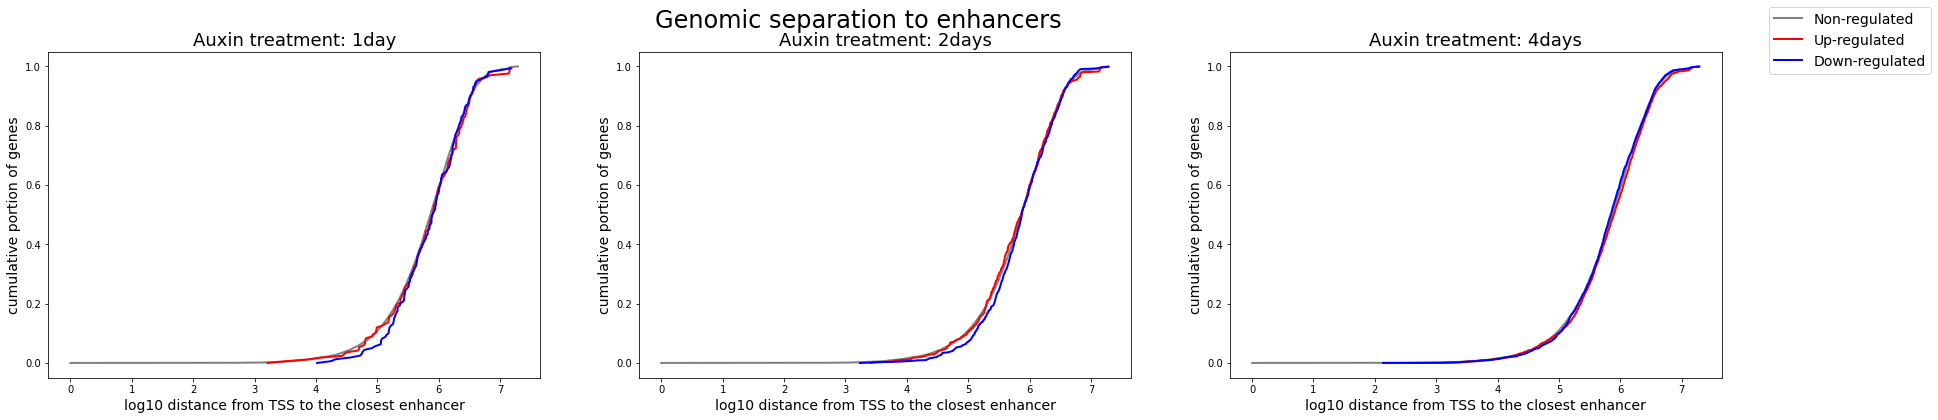

In [155]:
days = ['1day', '2days', '4days']

# Generating a subplot for each of the conditions
num_plots = len(days)
fig, axs = plt.subplots(1, num_plots, figsize=[num_plots*10, 6])
fig.suptitle("Genomic separation to enhancers", fontsize=24)

for day, ax in zip(days, axs.ravel()):
    
    up_reg = fpkm.iloc[np.where((fpkm[day + '.1'] == 'yes') & ((fpkm['CTCF-AID_untreated_mean_FPKM'] - fpkm['CTCF-AID_' + day + '_mean_FPKM']) > 0))]
    down_reg = fpkm.iloc[np.where((fpkm[day + '.1'] == 'yes') & ((fpkm['CTCF-AID_untreated_mean_FPKM'] - fpkm['CTCF-AID_' + day + '_mean_FPKM']) < 0))]
    non_reg = fpkm.iloc[np.where(fpkm[day + '.1'] == 'no')]
    
    # generate y axis: cumulative proportion of genes
    cum_all = np.arange(0, len(non_reg), 1)
    cum_all = cum_all/ len(non_reg)

    # plotting 
    ax.plot(np.log10(non_reg['distance_to_enhancer'].sort_values()), 
                cum_all, 
                color='grey',
                label='Non-regulated',
                linewidth=2)


    # generate y axis: cumulative proportion of genes
    cum_up = np.arange(0, len(up_reg), 1)
    cum_up = cum_up/ len(up_reg)

    ax.plot(np.log10(up_reg['distance_to_enhancer'].sort_values()), 
                cum_up, 
                color='red', 
                label='Up-regulated',
                linewidth=2)

    # generate y axis: cumulative proportion of genes
    cum_down = np.arange(0, len(down_reg), 1)
    cum_down = cum_down/ len(down_reg)

    ax.plot(np.log10(down_reg['distance_to_enhancer'].sort_values()),
                cum_down,
                color='blue',
                label='Down-regulated',
                linewidth=2)
    
    ax.set_title("Auxin treatment: " + day, fontsize=18)
    ax.set_xlabel("log10 distance from TSS to the closest enhancer", fontsize=14)
    ax.set_ylabel("cumulative portion of genes", fontsize=14)
    
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, fontsize=14)
plt.show()

# Scratch work / misc

### Below is work for generating first graph, was put into the for loop, above, but keeping in case process is easier to decipher in steps below

In [106]:
closest_intervals = bf.closest(tss_deseq_res, enhancer_coords, suffixes=('_de_tss','_enhancer'))
display(closest_intervals)
len(closest_intervals)

,gene_id_de_tss,baseMean_de_tss,log2FoldChange_de_tss,lfcSE_de_tss,stat_de_tss,pvalue_de_tss,padj_de_tss,chrom_de_tss,source_de_tss,feature_de_tss,...,score_de_tss,strand_de_tss,frame_de_tss,transcript_id_de_tss,distance_to_enhancer_de_tss,chrom_enhancer,start_enhancer,end_enhancer,value_enhancer,distance
0,ENSMUSG00000000544,2291.751812,-0.178754,0.255600,-0.699352,0.484332,0.999805,chr1,gffutils_derived,transcript,...,NaN,+,0,ENSMUST00000027847,25376,chr1,168055001,168056000,0.9624,4547
1,ENSMUSG00000000817,1.790351,-0.737808,1.908559,-0.386579,0.699068,NaN,chr1,gffutils_derived,transcript,...,NaN,-,0,ENSMUST00000000834,981964,chr1,162240001,162241000,0.8637,1477627
2,ENSMUSG00000001138,640.593647,-0.257097,0.262880,-0.978004,0.328073,0.999805,chr1,gffutils_derived,transcript,...,NaN,+,0,ENSMUST00000001166,3236924,chr1,36118001,36119000,0.8449,449711
3,ENSMUSG00000001143,115.038360,-0.475708,0.728265,-0.653207,0.513623,0.999805,chr1,gffutils_derived,transcript,...,NaN,-,0,ENSMUST00000001171,3096612,chr1,36118001,36119000,0.8449,383117
4,ENSMUSG00000001305,4027.317920,-0.101227,0.297815,-0.339898,0.733933,0.999805,chr1,gffutils_derived,transcript,...,NaN,-,0,ENSMUST00000001339,45628,chr1,188746001,188747000,0.8166,172763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25780,ENSMUSG00000069044,6.949773,1.272515,1.052337,1.209228,0.226575,0.999805,chrY,gffutils_derived,transcript,...,NaN,-,0,ENSMUST00000091188,2768326,<NA>,<NA>,<NA>,<NA>,<NA>
25781,ENSMUSG00000069045,160.679467,-0.292968,0.501614,-0.584051,0.559186,0.999805,chrY,gffutils_derived,transcript,...,NaN,-,0,ENSMUST00000091190,1453387,<NA>,<NA>,<NA>,<NA>,<NA>
25782,ENSMUSG00000069049,937.139720,0.148641,0.174857,0.850074,0.395284,0.999805,chrY,gffutils_derived,transcript,...,NaN,+,0,ENSMUST00000091197,179695,<NA>,<NA>,<NA>,<NA>,<NA>
25783,ENSMUSG00000069053,84.431660,-0.005782,0.369600,-0.015643,0.987519,0.999805,chrY,gffutils_derived,transcript,...,NaN,+,0,ENSMUST00000115894,67333,<NA>,<NA>,<NA>,<NA>,<NA>


25785

In [37]:
tss_deseq_res['distance_to_enhancer'] = closest_intervals['distance']

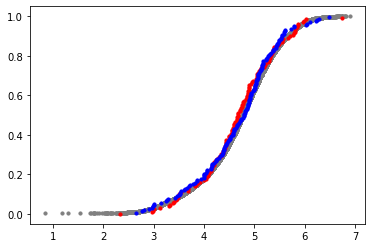

In [101]:
# generate y axis: cumulative proportion of genes
cum_all = np.arange(0, len(tss_deseq_res.iloc[nonsig_ix]), 1)
cum_all = cum_all/ len(tss_deseq_res.iloc[nonsig_ix])

plt.scatter(np.log10(tss_deseq_res.iloc[nonsig_ix]['distance_to_enhancer'].sort_values()), 
            cum_all, 
            color='grey',
            s=10,
            label='Non-regulated')


# generate y axis: cumulative proportion of genes
cum_up = np.arange(0, len(tss_deseq_res.iloc[up_ix]), 1)
cum_up = cum_up/ len(tss_deseq_res.iloc[up_ix])

plt.scatter(np.log10(tss_deseq_res.iloc[up_ix]['distance_to_enhancer'].sort_values()), 
            cum_up, 
            color='red', 
            s=10,
            label='Up-regulated')

# generate y axis: cumulative proportion of genes
cum_down = np.arange(0, len(tss_deseq_res.iloc[down_ix]), 1)
cum_down = cum_down/ len(tss_deseq_res.iloc[down_ix])

plt.scatter(np.log10(tss_deseq_res.iloc[down_ix]['distance_to_enhancer'].sort_values()),
            cum_down,
            color='blue',
            s=10,
            label='Down-regulated')
            